In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_benchmark(
    y: str,
    file_path: str = '/home/lg/sglang/实验/old/static_batch_results.jsonl'
):
    """
    Reads benchmark data from a JSONL file and plots a specified metric
    against the request rate.

    Args:
        y (str): The name of the metric to plot on the y-axis.
                 For example, 'request_throughput' or 'p99_e2e_latency_ms'.
        file_path (str, optional): The path to the JSONL benchmark report file.
                                   Defaults to '/home/lg/sglang/master_benchmark_report.jsonl'.
    """
    # --- 1. Validate Inputs ---
    if not y:
        print("Error: The 'y' parameter cannot be empty. Please specify a metric to plot.")
        return

    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' was not found.")
        print("Please provide a valid path to your benchmark report.")
        return

    # --- 2. Read and Parse Data ---
    data = []
    try:
        with open(file_path, 'r') as f:
            for line in f:
                # Skip empty lines
                if line.strip():
                    data.append(json.loads(line))
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from file: {e}")
        return
    except Exception as e:
        print(f"An unexpected error occurred while reading the file: {e}")
        return

    if not data:
        print("Error: The file is empty or contains no valid data.")
        return
        
    # Convert list of dictionaries to a pandas DataFrame for easy manipulation
    df = pd.DataFrame(data)

    # --- 3. Validate Data Columns ---
    x_axis = 'request_rate'
    if x_axis not in df.columns:
        print(f"Error: The required x-axis '{x_axis}' is not present in the data.")
        return
    if y not in df.columns:
        print(f"Error: The specified y-axis '{y}' is not present in the data.")
        available_columns = ", ".join(df.columns)
        print(f"Available metrics are: {available_columns}")
        return

    # Sort data by request_rate for a clean line plot
    df = df.sort_values(by=x_axis).reset_index(drop=True)

    # --- 4. Create and Display Plot ---
    plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style for the plot
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(df[x_axis], df[y], marker='o', linestyle='-', color='b')

    # Set titles and labels
    ax.set_title(f'{y} vs. {x_axis.replace("_", " ").title()}', fontsize=16)
    ax.set_xlabel(x_axis.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel(y.replace("_", " ").title(), fontsize=12)
    
    # Improve layout and display the plot
    plt.tight_layout()
    plt.show()

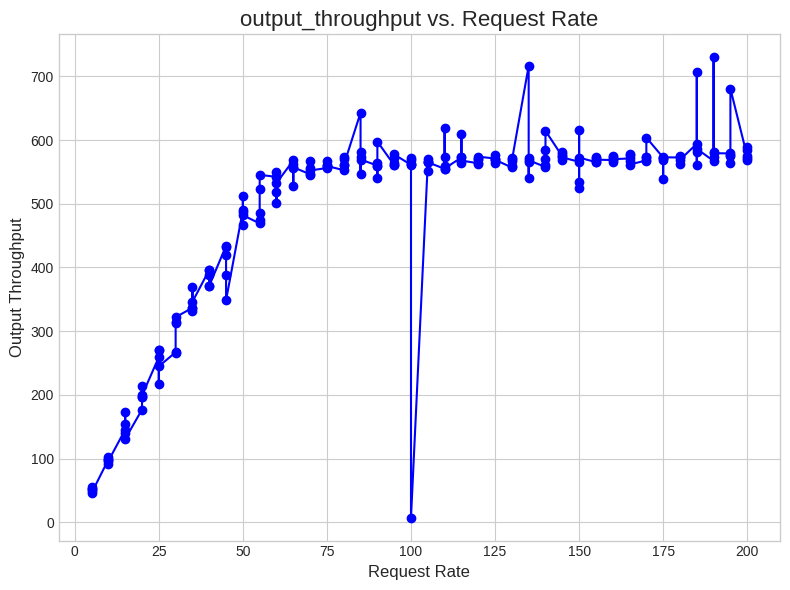

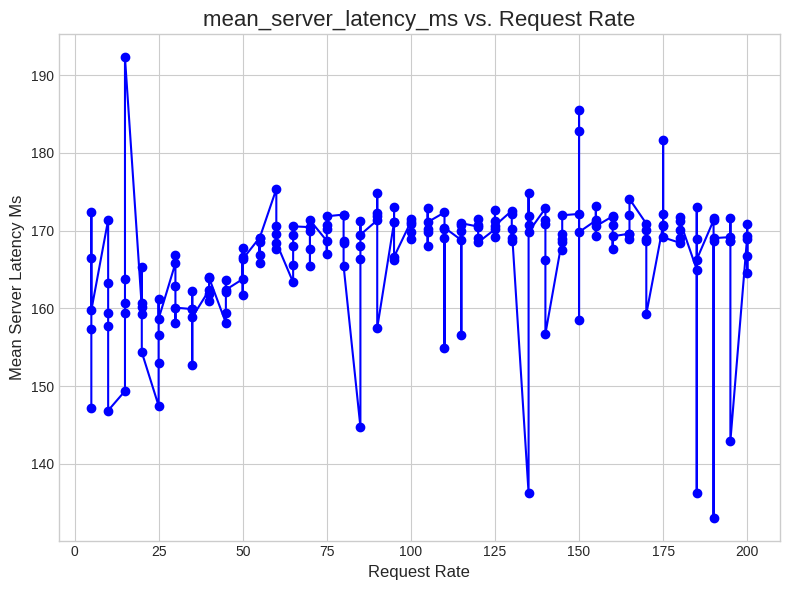

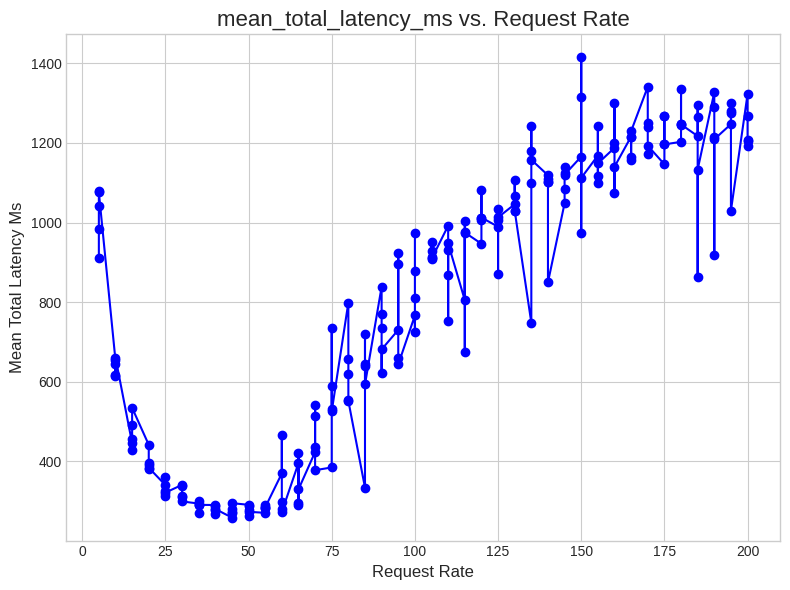

In [2]:
plot_benchmark(y='output_throughput')
plot_benchmark(y='mean_server_latency_ms')
plot_benchmark(y='mean_total_latency_ms')

In [3]:
import argparse
import json
from typing import List, Tuple

import numpy as np
import pandas as pd
from scipy.optimize import root
from scipy.special import lambertw # 我们保留它作为参考，但不再使用
import cxroots # 导入新库

# =================================================================
# --- 理论计算函数 (核心修正部分) ---
# =================================================================

def find_roots_scipy(K: int, rho: float) -> List[complex]:
    """
    使用 SciPy 的数值优化方法找到特征方程在单位圆内的 K-1 个根。
    这是一种比兰伯特W函数搜索更稳健的方法。
    """
    # 特征方程 f(z) = z^K - exp(-K*rho*(1-z))
    # 我们需要找到 f(z) = 0 的解
    def func(z_arr):
        z = complex(z_arr[0], z_arr[1])
        fz = z**K - np.exp(-K * rho * (1 - z))
        return [fz.real, fz.imag]

    # 论文指出，根 z_j 分布在单位圆内，且接近于单位根 e^(2*pi*i*j/K)
    # 我们就用这些单位根作为寻找真实根的初始猜测值
    initial_guesses = [
        np.exp(2j * np.pi * j / K) for j in range(1, K)
    ]

    roots = set()
    for guess in initial_guesses:
        # 对每个猜测值进行求解
        solution = root(func, [guess.real, guess.imag], method='hybr')
        if solution.success:
            z = complex(solution.x[0], solution.x[1])
            # 确认解在单位圆内且不为1
            if np.abs(z) < 1.0 and not np.isclose(z, 1.0):
                roots.add(round(z.real, 8) + 1j * round(z.imag, 8))
    
    return list(roots)

def find_roots_cxroots(K: int, rho: float) -> List[complex]:
    """
    使用 cxroots 库找到特征方程在单位圆内的 K-1 个根。
    """
    f = lambda z: z**K - np.exp(-K * rho * (1 - z))
    
    # --- 核心修改：将积分圆的半径从 1.0 稍微缩小一点 ---
    # 定义一个半径略小于1的圆作为积分路径，以避开边界上的根
    contour_radius = 1 - 1e-5 
    integration_contour = cxroots.Circle(0, contour_radius)
    
    # 在这个稍微收缩的路径内寻找根
    try:
        roots = integration_contour.roots(f).roots
    except RuntimeError as e:
        print(f"警告: 对于 ρ={rho:.3f}, cxroots 在半径 {contour_radius} 内积分失败。可能系统非常接近不稳定。错误: {e}")
        return [] # 返回空列表，表示求解失败

    # 因为我们的路径半径已经小于1，所以找到的所有根理论上都在单位圆内
    return roots

def find_roots_scipy_robust(K: int, rho: float) -> List[complex]:
    """
    使用一个加固的、尝试多种求解器的 SciPy 方法来寻找根。
    """
    def func_to_solve(z_arr):
        z = complex(z_arr[0], z_arr[1])
        fz = z**K - np.exp(-K * rho * (1 - z))
        return [fz.real, fz.imag]

    initial_guesses = [
        np.exp(2j * np.pi * j / K) for j in range(1, K)
    ]
    
    roots = set()
    # 定义我们要尝试的求解器列表
    solvers_to_try = ['hybr', 'lm', 'broyden1', 'anderson']

    for guess in initial_guesses:
        found_root_for_guess = False
        for solver in solvers_to_try:
            try:
                solution = root(
                    func_to_solve, 
                    [guess.real, guess.imag], 
                    method=solver,
                    # 增加迭代次数上限
                    options={'maxfev': 2000} 
                )
                if solution.success:
                    z = complex(solution.x[0], solution.x[1])
                    if np.abs(z) < 1.0 and not np.isclose(z, 1.0):
                        roots.add(round(z.real, 8) + 1j * round(z.imag, 8))
                        found_root_for_guess = True
                        # 只要有一个求解器成功了，就处理下一个初始猜测点
                        break 
            except Exception:
                # 某些求解器可能会对某些问题抛出异常，忽略并尝试下一个
                continue
        
        if not found_root_for_guess:
            # 如果所有求解器都失败了，我们才放弃这个初始点
            pass
            
    return list(roots)

def find_roots_scipy_robust_new(K: int, rho: float) -> List[complex]:
    """
    使用一个加固的、尝试多种求解器并调整容忍度的 SciPy 方法来寻找根。
    """
    def func_to_solve(z_arr):
        z = complex(z_arr[0], z_arr[1])
        fz = z**K - np.exp(-K * rho * (1 - z))
        return [fz.real, fz.imag]

    initial_guesses = [
        np.exp(2j * np.pi * j / K) for j in range(1, K)
    ]
    
    roots = set()
    solvers_to_try = ['hybr', 'lm'] # 'hybr' 和 'lm' 通常最稳健

    for guess in initial_guesses:
        found_root_for_guess = False
        for solver in solvers_to_try:
            try:
                # --- 核心修改：增加了 tol 参数，放宽收敛容忍度 ---
                solution = root(
                    func_to_solve, 
                    [guess.real, guess.imag], 
                    method=solver,
                    tol=1e-9 # 给予求解器更高的容忍度
                )
                if solution.success:
                    z = complex(solution.x[0], solution.x[1])
                    if np.abs(z) < 1.0 and not np.isclose(z, 1.0):
                        roots.add(round(z.real, 8) + 1j * round(z.imag, 8))
                        found_root_for_guess = True
                        break 
            except Exception:
                continue
        
        if not found_root_for_guess:
            pass
            
    return list(roots)

import numpy as np
from scipy.optimize import root
import mpmath
from typing import List

def find_roots_python_high_precision(K: int, rho: float) -> List[complex]:
    """
    使用 mpmath 高精度库来复现 MATLAB 的成功。
    这是解决当前问题的最可靠方法。
    """
    if not (0 <= rho < 1 and K > 1):
        return []

    # 1. 设置 mpmath 的计算精度 (dps = decimal places)
    # 默认是15位，我们增加到30位，这通常足以解决问题
    mpmath.mp.dps = 50 

    # 2. 在 mpmath 的精度下定义函数和常量
    # 注意：所有数学函数（exp, pi）和数字都需要使用 mpmath 版本
    k_mp = mpmath.mpf(K)
    rho_mp = mpmath.mpf(rho)
    
    def f_mpmath(z):
        return z**k_mp - mpmath.exp(-k_mp * rho_mp * (1 - z))

    # 3. 在 mpmath 的精度下创建初始猜测点
    # np.pi 是双精度，我们用 mpmath.pi
    initial_guesses = [
        mpmath.exp(2j * mpmath.pi * i / k_mp) for i in range(1, K)
    ]
    
    found_roots = set()
    
    # 4. 对每个猜测点调用 mpmath 的高精度求解器 findroot
    for guess in initial_guesses:
        try:
            # 'newton' 是 mpmath 中标准的求根器
            z_found = mpmath.findroot(f_mpmath, guess, solver='newton')
            
            # 5. 过滤和去重
            if abs(z_found) < 1:
                # 四舍五入到较低的位数（如10位）以进行有效的去重
                rounded_z = complex(round(z_found.real, 10), round(z_found.imag, 10))
                found_roots.add(rounded_z)
        except ValueError:
            # 如果 findroot 找不到解，它可能会抛出 ValueError
            # print(f"警告: mpmath 无法从猜测点 {guess} 收敛。")
            continue
            
    return list(found_roots)

In [4]:
def calculate_theoretical_queue_length(lam: float, K: int, S: float) -> Tuple[float, float]:
    """
    根据论文中的公式计算理论平均队列长度 E[N]。
    """
    if K <= 0 or S <= 0 or lam < 0:
        return None, None

    rho = lam * S / K
    if rho >= 1:
        return np.inf, rho # 系统不稳定，队列长度为无穷大

    p_u_prime_1 = (rho * (K + 1 - K * rho)) / (2 * (1 - rho))
    
    # 使用新的、更稳健的寻根函数
    roots = find_roots_python_high_precision(K, rho)
    
    # 检查根的数量是否正确
    # if len(roots) != K - 1:
    #     print(f"警告: 对于 ρ={rho:.3f}, 找到了 {len(roots)} 个根, 但期望找到 {K-1} 个。跳过此点的理论计算。")
    #     return None, rho
    
    sum_term = np.sum([1 / (1 - z) for z in roots])
    expected_n = p_u_prime_1 + sum_term.real
    
    return expected_n, rho

In [5]:
def calculate_avg_service_time(filepath: str) -> Tuple[float, float]:
    latencies_ms = []
    with open(filepath, 'r') as f:
        for line in f:
            try:
                record = json.loads(line)
                if 'mean_server_latency_ms' in record:
                    latencies_ms.append(record['mean_server_latency_ms'])
            except json.JSONDecodeError:
                print(f"警告: 跳过无法解析的行: {line.strip()}")
                continue
    if not latencies_ms:
        raise ValueError("文件中没有找到'mean_server_latency_ms'数据。")
    mean_latency_ms = np.mean(latencies_ms)
    std_latency_ms = np.std(latencies_ms)
    return mean_latency_ms / 1000.0, std_latency_ms / 1000.0

In [6]:
def compare_theory_vs_experiment(filepath: str, avg_service_time_s: float) -> pd.DataFrame:
    comparison_data = []
    with open(filepath, 'r') as f:
        for line in f:
            try:
                record = json.loads(line)
            except json.JSONDecodeError:
                continue

            lam = record['request_rate']
            K = record['batch_size']
            W_total_s = record['mean_total_latency_ms'] / 1000.0
            n_experimental = lam * W_total_s
            
            n_theoretical, rho = calculate_theoretical_queue_length(lam, K, avg_service_time_s)

            comparison_data.append({
                "Arrival_Rate_λ": lam,
                "Traffic_Intensity_ρ": rho,
                "N_Experimental": n_experimental,
                "N_Theoretical": n_theoretical,
                "W_Total_Latency_ms": record['mean_total_latency_ms'],
                "S_Server_Latency_ms": record['mean_server_latency_ms']
            })
            
    df = pd.DataFrame(comparison_data)
    # 合并重复的rate行，取均值
    #df = df.groupby("Arrival_Rate_λ").mean().reset_index()
    return df

In [7]:
avg_S, std_S = calculate_avg_service_time(filepath="/home/lg/sglang/实验/old/static_batch_results.jsonl")
print(f"全局平均服务时间 S = {avg_S:.6f} 秒 (标准差 = {std_S:.6f})")
print("将使用这个S值作为理论模型中的固定服务时间。")

全局平均服务时间 S = 0.166750 秒 (标准差 = 0.007567)
将使用这个S值作为理论模型中的固定服务时间。


In [9]:
print("\n--- Step 2: Comparing Experimental Results with Theoretical Predictions ---")
results_df = compare_theory_vs_experiment("/home/lg/sglang/实验/old/static_batch_results.jsonl", avg_S)


--- Step 2: Comparing Experimental Results with Theoretical Predictions ---


KeyError: 'mean_total_latency_ms'

In [374]:
# 删除包含inf的行
results_df = results_df.replace([np.inf, -np.inf], np.nan).dropna()
#results_df = results_df.groupby("Arrival_Rate_λ").mean().reset_index()

In [375]:
df=results_df
df

,Arrival_Rate_λ,Traffic_Intensity_ρ,N_Experimental,N_Theoretical,W_Total_Latency_ms,S_Server_Latency_ms
0,30.0,0.500250,10.234530,6.436045,341.151013,165.816381
1,30.0,0.500250,8.986056,6.436045,299.535208,160.086563
2,30.0,0.500250,10.158687,6.436045,338.622891,162.925047
3,30.0,0.500250,9.350446,6.436045,311.681529,166.896129
4,30.0,0.500250,9.430582,6.436045,314.352742,158.149071
5,5.0,0.083375,4.556630,5.333751,911.326053,147.107977
6,10.0,0.166750,6.610657,6.167503,661.065701,146.844077
7,15.0,0.250125,6.685593,5.749698,445.706170,149.355948
8,20.0,0.333500,7.685884,6.426461,384.294180,154.352056
9,25.0,0.416875,8.516926,5.754723,340.677021,147.462717


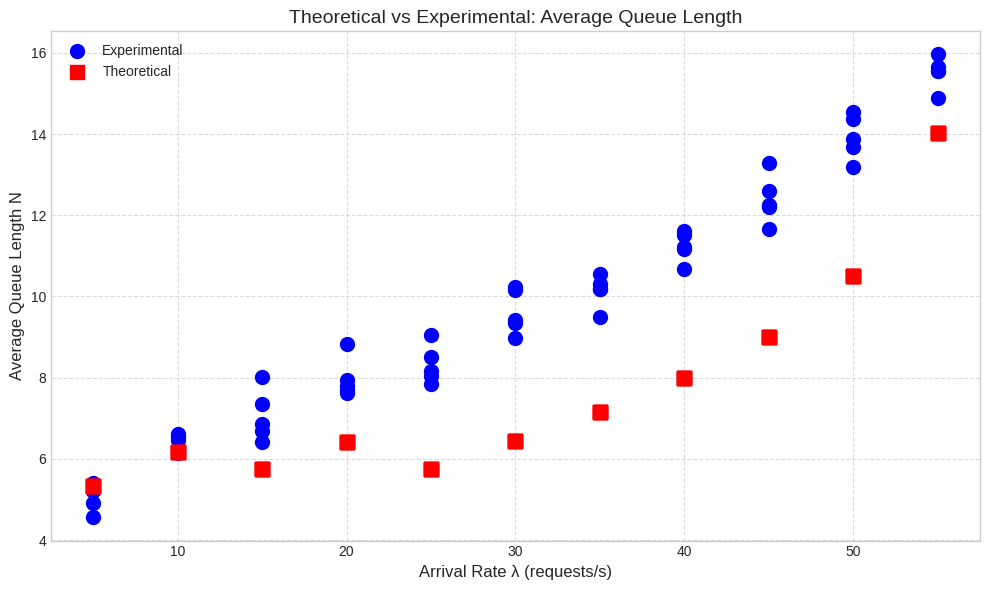

In [376]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df["Arrival_Rate_λ"], results_df["N_Experimental"], 
           marker='o', label='Experimental', color='blue', s=100)
plt.scatter(results_df["Arrival_Rate_λ"], results_df["N_Theoretical"], 
           marker='s', label='Theoretical', color='red', s=100)

plt.xlabel('Arrival Rate λ (requests/s)', fontsize=12)
plt.ylabel('Average Queue Length N', fontsize=12)
plt.title('Theoretical vs Experimental: Average Queue Length', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()